In [2]:
import librosa
import numpy as np
import os
import pandas as pd

In [3]:
# Feature Extraction Functions

# 1. Energy and Power
def extract_energy(speech):
    return librosa.feature.rms(y=speech)[0]  # Root mean square energy

# 2. Pitch (Fundamental Frequency) Statistics
def extract_pitch(speech, rate):
    pitch, _ = librosa.core.piptrack(y=speech, sr=rate)
    pitch = pitch[pitch > 0]  # Remove zero values
    return pitch

# 3. Pitch Statistics
def pitch_stats(pitch):
    min_pitch = np.min(pitch)
    max_pitch = np.max(pitch)
    mean_pitch = np.mean(pitch)
    pitch_sd = np.std(pitch)
    pitch_abs = np.mean(np.abs(pitch))
    pitch_quant = np.quantile(pitch, [0.25, 0.5, 0.75])
    diff_pitch_max_min = max_pitch - min_pitch
    diff_pitch_max_mean = max_pitch - mean_pitch
    diff_pitch_max_mode = max_pitch - np.median(pitch)
    return min_pitch, max_pitch, mean_pitch, pitch_sd, pitch_abs, pitch_quant, diff_pitch_max_min, diff_pitch_max_mean, diff_pitch_max_mode

# 4. Intensity (RMS)
def intensity_features(speech):
    intensity = librosa.feature.rms(y=speech)[0]
    intensity_min = np.min(intensity)
    intensity_max = np.max(intensity)
    intensity_mean = np.mean(intensity)
    intensity_sd = np.std(intensity)
    intensity_quant = np.quantile(intensity, [0.25, 0.5, 0.75])
    diff_int_max_min = intensity_max - intensity_min
    diff_int_max_mean = intensity_max - intensity_mean
    diff_int_max_mode = intensity_max - np.median(intensity)
    return intensity_min, intensity_max, intensity_mean, intensity_sd, intensity_quant, diff_int_max_min, diff_int_max_mean, diff_int_max_mode

# 5. Jitter and Shimmer
def jitter_shimmer(speech, rate):
    # Jitter: Measure of pitch variation
    pitch, voiced_flag = librosa.core.piptrack(y=speech, sr=rate)
    jitter = np.std(pitch[pitch > 0])
    
    # Shimmer: Measure of amplitude variation (calculated based on RMS)
    intensity = librosa.feature.rms(y=speech)[0]
    shimmer = np.std(intensity)
    
    return jitter, shimmer

# 6. Speech Rate and Pauses
def speech_rate(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    speak_rate = len(onset_frames) / (len(speech) / rate)  # Onsets per second
    return speak_rate

def pause_features(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    intervals = librosa.frames_to_time(onset_frames, sr=rate)  # Time intervals between onsets
    pauses = np.diff(intervals)  # Calculate pause durations
    max_pause = np.max(pauses) if len(pauses) > 0 else 0
    avg_pause = np.mean(pauses) if len(pauses) > 0 else 0
    total_pause_duration = np.sum(pauses)
    return max_pause, avg_pause, total_pause_duration

# 7. Rising and Falling Edges (Pitch changes)
def rising_falling_edges(pitch):
    rising = np.sum(np.diff(pitch) > 0)
    falling = np.sum(np.diff(pitch) < 0)
    max_rising = np.max(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    max_falling = np.min(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    avg_rise = np.mean(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    avg_fall = np.mean(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    return rising, falling, max_rising, max_falling, avg_rise, avg_fall

# 8. Loudness (RMS energy)
def loudness(speech):
    return librosa.feature.rms(y=speech)[0]


In [4]:
def getPassOrFail(df, person_id, column_name):
    """
    Calculate the average score for a given person and column.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        person_id (str): The participant ID (e.g., "p1").
        column_name (str): The name of the column to average (e.g., "Overall").

    Returns:
        float: The average score for the specified column and person.
    """
    person_data = df[df["Participant"] == person_id]
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in dataframe.")
    if person_data.empty:
        raise ValueError(f"No data found for participant '{person_id}'.")
    
    averageScore = person_data[column_name].astype(float).mean()

    if averageScore >= 5:
        return 1 # Pass
    else:
        return 0 # Fail


In [ ]:
# Create a DataFrame to store the features 

import pandas as pd
import numpy as np
import os


# Create a DataFrame to store the features

# I want this dataframe to have the following columns:
# 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 'Total Pause Duration'

# The first column should be the filename of the audio file
# The last column should be whether they passed or failed the interview, for now just set it to 'pass'


# Step 1: Create an empty DataFrame
df = pd.DataFrame(columns=['Filename', 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 'Total Pause Duration', 'Result'])


df_prosodic_features = pd.read_csv('../MIT_INTERVIEW_DATASET/Prosody/prosodic_features.csv')


df_labels_from_turkers = pd.read_csv('../MIT_INTERVIEW_DATASET/Labels/turker_scores_full_interview.csv')

# Step 2: Loop through the audio files and extract features

rows = []

for i in range(90):
    AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/P{i}.wav'
    if os.path.exists(AUDIO_FILE):
        speech, rate = librosa.load(AUDIO_FILE, sr=16000)
        energy = extract_energy(speech)
        pitch = extract_pitch(speech, rate)
        min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
        intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
        jitter, shimmer = jitter_shimmer(speech, rate)
        speak_rate = speech_rate(speech, rate)
        max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
        
        rowNameFromTurkers = f"p{i}"
        columnNameFromTurkers = "Overall"
        passOrFail = getPassOrFail(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

        print(f"passOrFail: {passOrFail}")


        rows.append({
            'Filename': AUDIO_FILE,
            'Energy': np.mean(energy),
            'Pitch Min': min_pitch,
            'Pitch Max': max_pitch,
            'Pitch Mean': mean_pitch,
            'Pitch Std Dev': pitch_sd,
            'Intensity Min': intensity_min,
            'Intensity Max': intensity_max,
            'Intensity Mean': intensity_mean,
            'Jitter': jitter,
            'Shimmer': shimmer,
            'Speech Rate': speak_rate,
            'Max Pause': max_pause,
            'Avg Pause': avg_pause,
            'Total Pause Duration': total_pause_duration,
            'Result': passOrFail
        })
    

    AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/PP{i}.wav'
    if os.path.exists(AUDIO_FILE):
        speech, rate = librosa.load(AUDIO_FILE, sr=16000)
        energy = extract_energy(speech)
        pitch = extract_pitch(speech, rate)
        min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
        intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
        jitter, shimmer = jitter_shimmer(speech, rate)
        speak_rate = speech_rate(speech, rate)
        max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
        
        rowNameFromTurkers = f"p{i}"
        columnNameFromTurkers = "Overall"
        passOrFail = getPassOrFail(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

        print(f"passOrFail: {passOrFail}")


        rows.append({
            'Filename': AUDIO_FILE,
            'Energy': np.mean(energy),
            'Pitch Min': min_pitch,
            'Pitch Max': max_pitch,
            'Pitch Mean': mean_pitch,
            'Pitch Std Dev': pitch_sd,
            'Intensity Min': intensity_min,
            'Intensity Max': intensity_max,
            'Intensity Mean': intensity_mean,
            'Jitter': jitter,
            'Shimmer': shimmer,
            'Speech Rate': speak_rate,
            'Max Pause': max_pause,
            'Avg Pause': avg_pause,
            'Total Pause Duration': total_pause_duration,
            'Result': passOrFail
        })




passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOrFail: 1
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 0
passOrFail: 1
passOr

In [14]:
# Now create DataFrame
df = pd.DataFrame(rows)

df.to_csv('../2-VocalTone-(Prosody)/prosodic_features_from_MIT_videos_with_results.csv', index=False)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Prepare features and labels
X = df.drop(columns=['Filename', 'Result'])  # Features
y = df['Result']  # Labels (0 = Fail, 1 = Pass)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:


# Step 4: Train the model (Random Forest in this case)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[ 7  9]
 [ 0 12]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.61        16
           1       0.57      1.00      0.73        12

    accuracy                           0.68        28
   macro avg       0.79      0.72      0.67        28
weighted avg       0.82      0.68      0.66        28


Accuracy Score: 0.6785714285714286


In [8]:
import joblib

# Save the trained model
joblib.dump(clf, 'interview_pass_fail_model-try1-67Percent.pkl')

# Save the scaler as well
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [9]:
# Get model back 

loaded_model = joblib.load('interview_pass_fail_model-try1-67Percent.pkl')
loaded_scaler = joblib.load('scaler.pkl')


# new_data = None
# new_data_Scaled = loaded_scaler.transform(new_data)

# prediction = loaded_model.predict(new_data_Scaled)


### Evaluation Metrics

1. F1 Score
2. AUC ROC
3. Confusion Matrix
4. Accuracy
5. Precision & Recall


ROC AUC Score: 0.7578124999999999


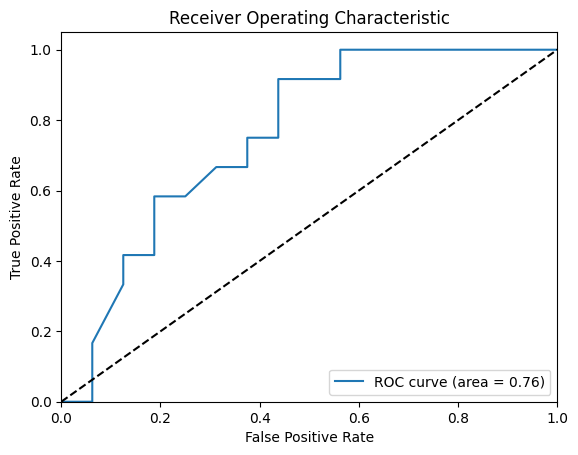

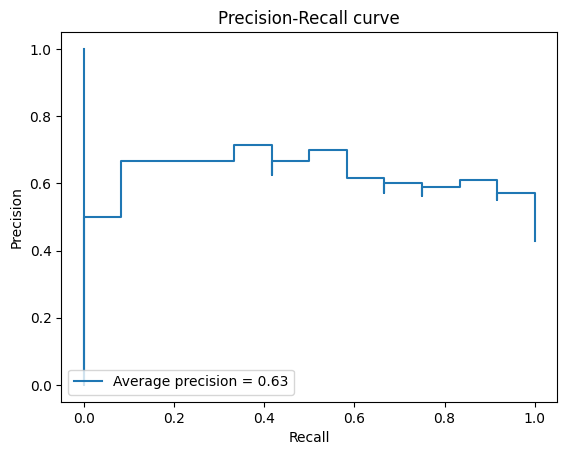

Accuracy: 0.6785714285714286


/var/folders/s2/__5bgsnj1_q86m6cbx0wbr7r0000gn/T/ipykernel_31358/3357216542.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy'], y=[accuracy], palette='viridis')


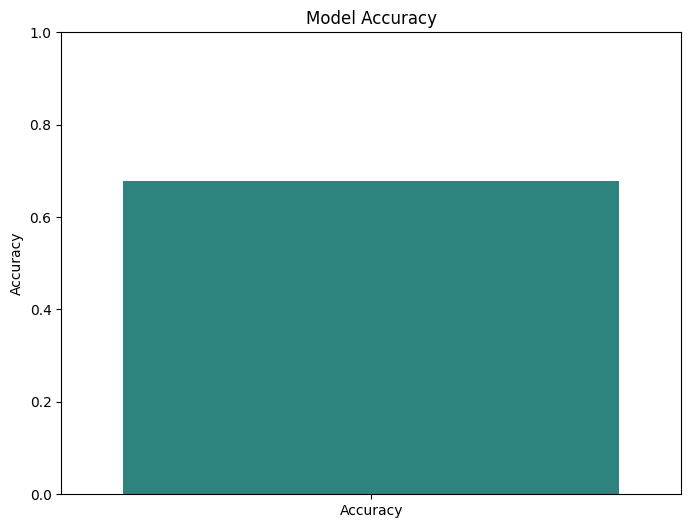

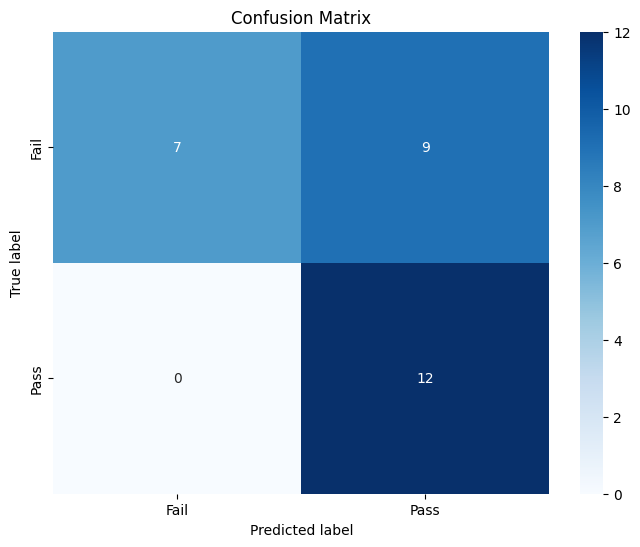

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate ROC AUC

# do using the loaded_model and not clf
y_pred_proba = loaded_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Calcualte precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.step(recall, precision, where='post', label='Average precision = {:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


# Calculate accuracy and plot it
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize=(8, 6))
sns.barplot(x=['Accuracy'], y=[accuracy], palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

# Calculate Confusion Matrix and plot it
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()



In [11]:
# Calculate f1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.7272727272727273
Precision: 0.5714285714285714
Recall: 1.0


### Adding the First Impressions V2 Dataset to Training

In [ ]:
# Extract Labels from pkl file

import pickle

pkl_file = '../FirstImpression'
# Replace 'your_file.pkl' with the path to your pickle file
with open('your_file.pkl', 'rb') as file:
    data = pickle.load(file)

# Now `data` contains the Python object stored in the .pkl file
print(data)
